<a href="https://colab.research.google.com/github/denis5ds/IA-sis420/blob/main/Copia_de_2ndoparcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
class Board():
    def __init__(self):
        self.state = np.zeros((6, 7))  # Inicializa un tablero de 6 filas por 7 columnas con ceros (vacío).

    def valid_moves(self):
        return [j for j in range(3) if self.state[0, j] == 0]  # Devuelve una lista de columnas donde la parte superior está vacía, es decir, movimientos válidos.

    def update(self, symbol, col):
        for row in range(5, -1, -1):  # Empieza desde la última fila (inferior) y busca la primera celda vacía.
            if self.state[row, col] == 0:
                self.state[row, col] = symbol  # Coloca el símbolo del jugador en esa celda.
                return row, col  # Devuelve la posición (fila, columna) donde se hizo la actualización.
        raise ValueError("Columna llena!")  # Lanza un error si la columna está llena.

    def is_game_over(self):
        # Verifica si hay un ganador en filas, columnas o diagonales.
        for row in range(6):
            for col in range(7):
                # Verificación de cuatro en línea horizontal
                if col + 3 < 7 and np.all(self.state[row, col:col + 4] == self.state[row, col]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de cuatro en línea vertical
                if row + 3 < 6 and np.all(self.state[row:row + 4, col] == self.state[row, col]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de diagonal ascendente
                if col + 3 < 7 and row + 3 < 6 and np.all([self.state[row + i, col + i] == self.state[row, col] for i in range(4)]) and self.state[row, col] != 0:
                    return self.state[row, col]
                # Verificación de diagonal descendente
                if col - 3 >= 0 and row + 3 < 6 and np.all([self.state[row + i, col - i] == self.state[row, col] for i in range(4)]) and self.state[row, col] != 0:
                    return self.state[row, col]
        # Si no hay movimientos válidos, es un empate.
        if len(self.valid_moves()) == 0:
            return 0
        # El juego continúa.
        return None

    def reset(self):
        self.state = np.zeros((6, 7))  # Reinicia el tablero.

In [ ]:

class Game():
    # Método constructor de la clase Game
    def __init__(self, player1, player2):
        # Asigna un símbolo a cada jugador: el jugador 1 tiene el símbolo 1 y el jugador 2 tiene el símbolo -1
        player1.symbol = 1
        player2.symbol = -1

        # Se crea una lista de jugadores y se les asigna a la propiedad 'players' de la clase
        self.players = [player1, player2]

        # Se crea una instancia del tablero de juego (supongo que Board es otra clase que no has incluido)
        self.board = Board()

    # Método que simula juegos entre los dos jugadores de forma iterativa
    def selfplay(self, rounds=100):
        # Lista para llevar el registro de victorias de cada jugador (0 para jugador 1 y 1 para jugador 2)
        wins = [0, 0]

        # Bucle principal que se ejecuta durante la cantidad de rondas especificada (por defecto, 100)
        for i in range(1, rounds + 1):
            # Reseteamos el tablero antes de empezar cada partida
            self.board.reset()

            # Reseteamos el estado de los jugadores antes de cada juego
            for player in self.players:
                player.reset()

            game_over = False  # Bandera que indica si el juego ha terminado o no

            # Bucle que sigue corriendo hasta que el juego termine
            while not game_over:
                # Cada jugador hace su movimiento en el tablero
                for player in self.players:
                    # El jugador toma una acción (esto parece depender de un método 'move' del jugador)
                    action = player.move(self.board)

                    # Se actualiza el tablero con el movimiento del jugador y se obtiene la fila y columna actualizadas
                    row, col = self.board.update(player.symbol, action)

                    # El jugador actualiza su conocimiento sobre el estado del tablero
                    player.update(self.board)

                    # Verificamos si el juego ha terminado (puede retornar un símbolo o None si no ha terminado)
                    if self.board.is_game_over() is not None:
                        # Si el juego terminó, terminamos el bucle interno
                        game_over = True
                        break

            # Llamamos a la función de recompensa al finalizar cada juego
            self.reward()

            # Comprobamos quién ganó el juego (según el estado final del tablero)
            for ix, player in enumerate(self.players):
                if self.board.is_game_over() == player.symbol:
                    # Incrementamos la victoria del jugador correspondiente
                    wins[ix] += 1

            # Imprimimos las victorias de los jugadores en ciertas iteraciones
            if i in [500, 1000, 5000]:
                print(f"Iteración {i}: Victorias - Jugador 1: {wins[0]}, Jugador 2: {wins[1]}")

        # Al final de las rondas, retornamos la cantidad total de victorias de ambos jugadores
        return wins

    # Método para asignar recompensas a los jugadores tras cada juego
    def reward(self):
        # Comprobamos el resultado del juego: None (si el juego no ha terminado), 0 (empate), 1 o -1 (si alguno de los jugadores ganó)
        winner = self.board.is_game_over()

        if winner == 0:  # Si es empate (0), premiamos a ambos jugadores con 0.5
            for player in self.players:
                player.reward(0.5)
        else:  # Si hubo un ganador, el ganador recibe 1 y el perdedor recibe 0
            for player in self.players:
                if winner == player.symbol:
                    # Recompensamos al ganador con 1
                    player.reward(1)
                else:
                    # Recompensamos al perdedor con 0
                    player.reward(0)

In [ ]:

import numpy as np

class Agent():
    def __init__(self, alpha=0.5, prob_exp=0.5):
        # Inicializa los parámetros del agente
        self.value_function = {}  # Diccionario que almacena el valor de cada estado del juego (estado -> valor)
        self.alpha = alpha         # Tasa de aprendizaje (learning rate), controla cuánto actualiza el agente su conocimiento
        self.positions = []        # Lista que guarda todas las posiciones (estados) visitadas durante un juego
        self.prob_exp = prob_exp   # Probabilidad de explorar, controla cuánto el agente prefiere explorar en lugar de explotar

    def reset(self):
        # Resetea el historial de posiciones del agente, se llama al inicio de cada juego
        self.positions = []

    def move(self, board, explore=True):
        # Devuelve la columna donde el agente va a hacer su próximo movimiento
        valid_moves = board.valid_moves()  # Obtiene todas las columnas válidas donde el agente puede poner una ficha

        # Si el agente está en modo de exploración (explore=True), elige un movimiento aleatorio
        if explore and np.random.uniform(0, 1) < self.prob_exp:
            return np.random.choice(valid_moves)  # Selección aleatoria de una columna válida

        # Si el agente está en modo de explotación (exploitación: el agente usa su conocimiento para tomar la mejor acción)
        max_value = -1000  # Inicializa el valor máximo encontrado como muy bajo
        for col in valid_moves:
            # Para cada columna válida, simula el movimiento en el tablero
            next_board = board.state.copy()  # Copia el estado actual del tablero
            for row in range(5, -1, -1):  # Busca la fila más baja disponible en la columna actual
                if next_board[row, col] == 0:  # Si la celda está vacía (0), se puede hacer un movimiento
                    next_board[row, col] = self.symbol  # Realiza el movimiento del agente (su símbolo)
                    break  # Sale del bucle una vez realizado el movimiento

            # Convierte el estado del tablero en un string para usarlo como una clave en el diccionario
            next_state = str(next_board.reshape(6 * 7))
            # Obtiene el valor del estado futuro (si no existe en la tabla, toma valor 0)
            value = 0 if self.value_function.get(next_state) is None else self.value_function.get(next_state)

            # Si el valor del estado es mayor que el valor máximo actual, actualiza el valor máximo y la mejor columna
            if value >= max_value:
                max_value = value
                best_col = col

        # Devuelve la columna con el valor máximo estimado
        return best_col

    def update(self, board):
        # Registra la posición (estado del tablero) en la lista de posiciones visitadas
        self.positions.append(str(board.state.reshape(6 * 7)))

    def reward(self, reward):
        # Actualiza la tabla de valores de la función de valor usando el algoritmo TD(0) (Temporal Difference)
        # Recorre las posiciones visitadas en orden inverso (desde el final del juego hacia el inicio)
        for p in reversed(self.positions):
            # Si no existe una entrada para este estado, la inicializamos con 0
            if self.value_function.get(p) is None:
                self.value_function[p] = 0

            # Actualiza el valor del estado utilizando la fórmula TD(0):
            # V(s) <- V(s) + α * (R - V(s))
            # Donde:
            # - V(s) es el valor del estado actual
            # - α es la tasa de aprendizaje
            # - R es la recompensa obtenida en este estado
            self.value_function[p] += self.alpha * (reward - self.value_function[p])

            # La recompensa se actualiza para ser el nuevo valor del estado
            reward = self.value_function[p]  # Propaga la recompensa hacia los estados anteriores

In [ ]:
# Entrenar los agentes
agent1 = Agent(prob_exp=0.5)
agent2 = Agent()

game = Game(agent1, agent2)
game.selfplay(1000)

Iteración 500: Victorias - Jugador 1: 36, Jugador 2: 48
Iteración 1000: Victorias - Jugador 1: 90, Jugador 2: 90


[90, 90]

In [ ]:
import pandas as pd

# Ordenar la función de valor por el valor de la recompensa (de mayor a menor)
funcion_de_valor = sorted(agent1.value_function.items(), key=lambda kv: kv[1], reverse=True)

# Crear el DataFrame
tabla = pd.DataFrame({
    'estado': [x[0] for x in funcion_de_valor],  # Estado
    'valor': [x[1] for x in funcion_de_valor]    # Valor
})

# Limitar el número de filas a mostrar (por ejemplo, las primeras 20)
tabla_limited = tabla.head(20)

# Mejorar la visualización de la tabla
tabla_limited.style.set_table_styles(
    [{'selector': 'thead th',
      'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
     {'selector': 'tbody td',
      'props': [('text-align', 'center'), ('font-family', 'Arial')]}]
).set_properties(**{'border': '1px solid black', 'border-collapse': 'collapse'}).hide(axis='index')

# Imprimir la tabla
print(tabla_limited)

                                               estado     valor
0   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.984375
1   [ 1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  ...  0.937500
2   [ 0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  0.  ...  0.875000
3   [ 1.  0. -1.  0.  0.  0.  0.  1. -1.  1.  0.  ...  0.875000
4   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.875000
5   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.875000
6   [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  ...  0.761719
7   [ 0.  0.  1.  0.  0.  0.  0.  0. -1.  1.  0.  ...  0.750000
8   [-1.  0.  1.  0.  0.  0.  0. -1.  0.  1.  0.  ...  0.750000
9   [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.750000
10  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  ...  0.750000
11  [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  1.  0.  ...  0.750000
12  [ 0.  0. -1.  0.  0.  0.  0.  1.  0.  1.  0.  ...  0.703125
13  [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  ...  0.562500
14  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.

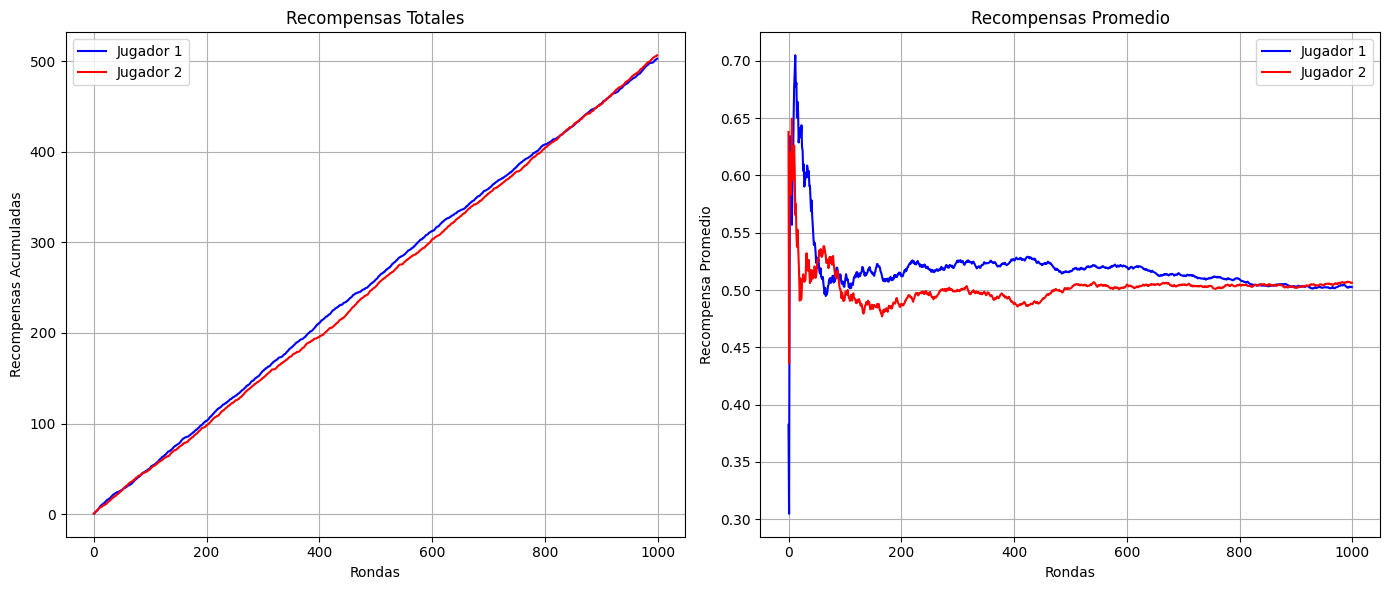

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos simulados: asumimos que `total_rewards_p1` y `total_rewards_p2` representan recompensas acumuladas por ronda
# Suponiendo 1000 rondas para los agentes
rounds = 1000
total_rewards_p1 = np.cumsum(np.random.rand(rounds))  # Recompensas acumuladas del jugador 1 (simulado)
total_rewards_p2 = np.cumsum(np.random.rand(rounds))  # Recompensas acumuladas del jugador 2 (simulado)

# Cálculo de las recompensas promedio
average_rewards_p1 = total_rewards_p1 / (np.arange(1, rounds + 1))
average_rewards_p2 = total_rewards_p2 / (np.arange(1, rounds + 1))

# Configurar la visualización de los gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Recompensas Totales
ax1.plot(total_rewards_p1, label="Jugador 1", color='blue')
ax1.plot(total_rewards_p2, label="Jugador 2", color='red')
ax1.set_title("Recompensas Totales")
ax1.set_xlabel("Rondas")
ax1.set_ylabel("Recompensas Acumuladas")
ax1.legend()
ax1.grid(True)

# Gráfico 2: Recompensas Promedio
ax2.plot(average_rewards_p1, label="Jugador 1", color='blue')
ax2.plot(average_rewards_p2, label="Jugador 2", color='red')
ax2.set_title("Recompensas Promedio")
ax2.set_xlabel("Rondas")
ax2.set_ylabel("Recompensa Promedio")
ax2.legend()
ax2.grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [ ]:
import random

class AIPlayer:
    def __init__(self, symbol):
        self.symbol = symbol

    def move(self, board):
        # Simple AI logic: chooses a random valid move
        valid_moves = board.valid_moves()
        return random.choice(valid_moves)

    def update(self, board):
        pass  # No need to update anything for this simple AI

    def reset(self):
        pass  # No need to reset anything for this simple AI

    def reward(self, reward_value):
        pass  # Simple AI does not use rewards, but function is needed for compatibility

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_board(board_state):
    plt.imshow(board_state, cmap='cool', origin='upper')
    plt.colorbar(ticks=[-1, 0, 1], label='Player')
    plt.xticks(range(7))
    plt.yticks(range(6))
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title('Conecta 4 - Estado del Tablero')
    plt.show()

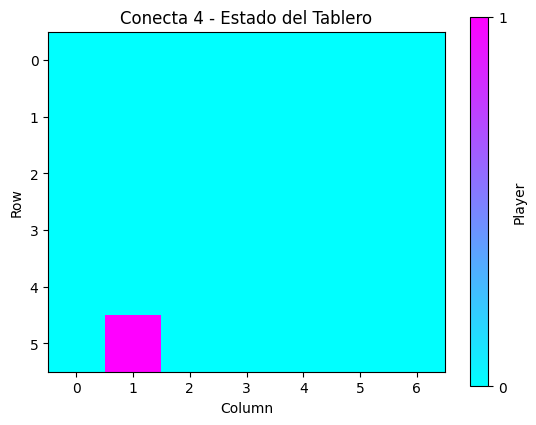

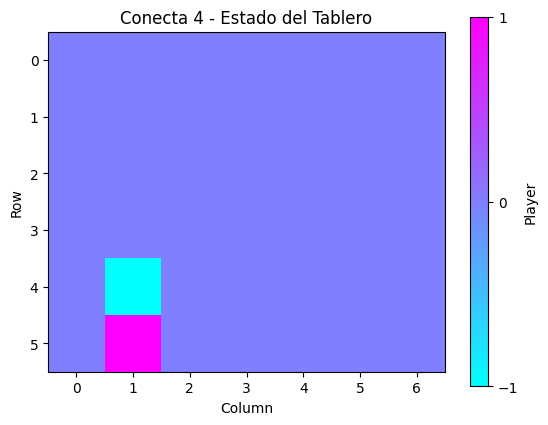

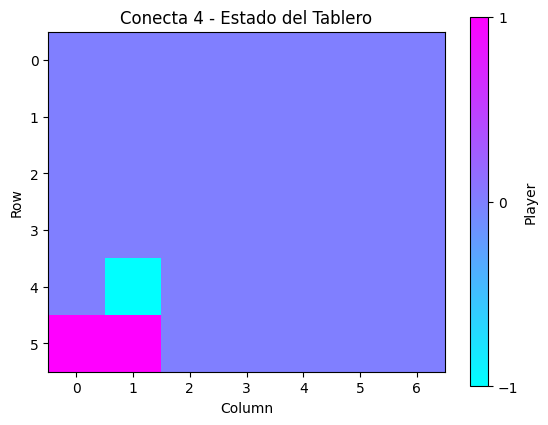

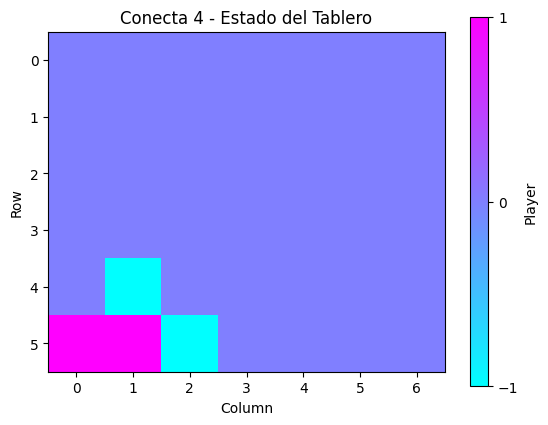

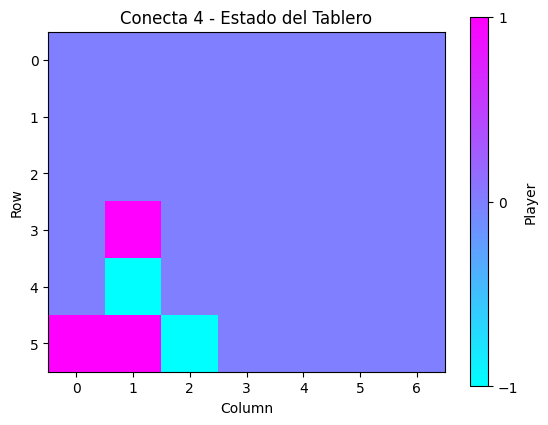

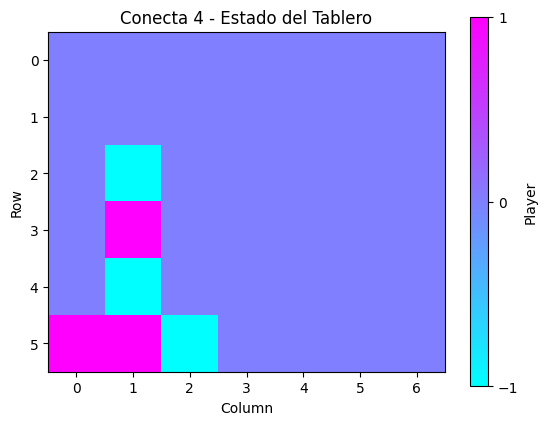

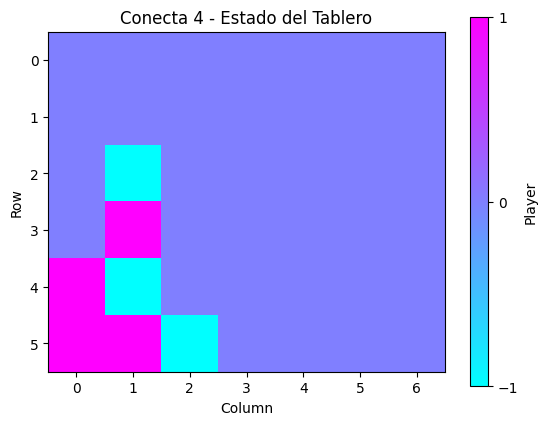

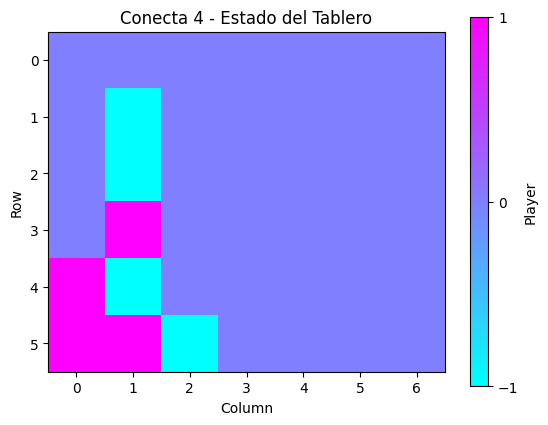

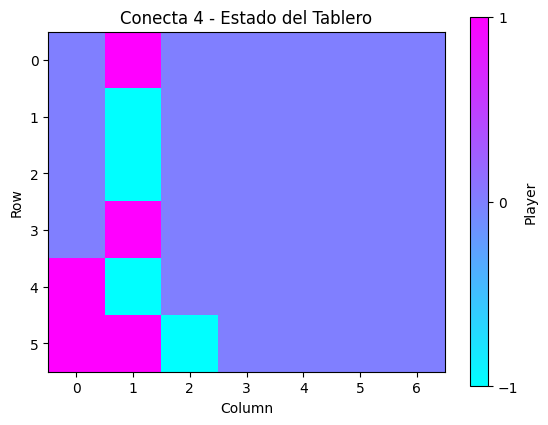

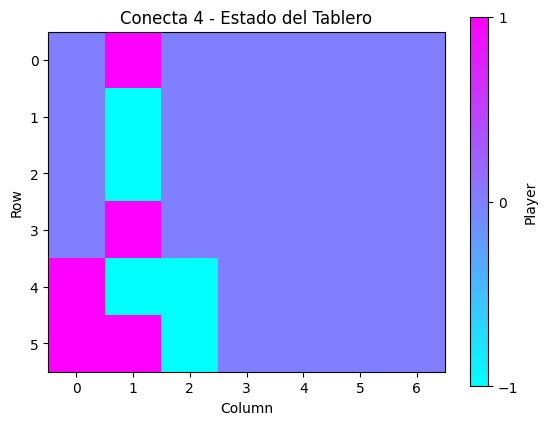

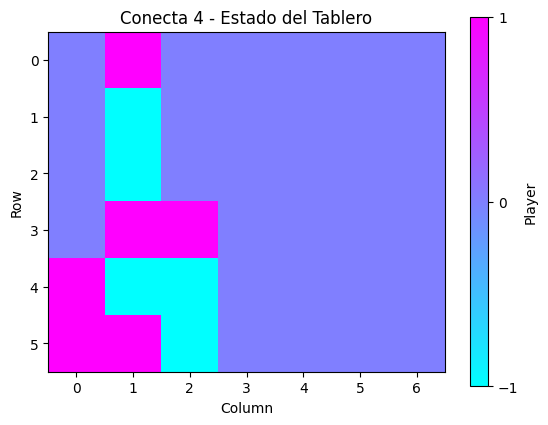

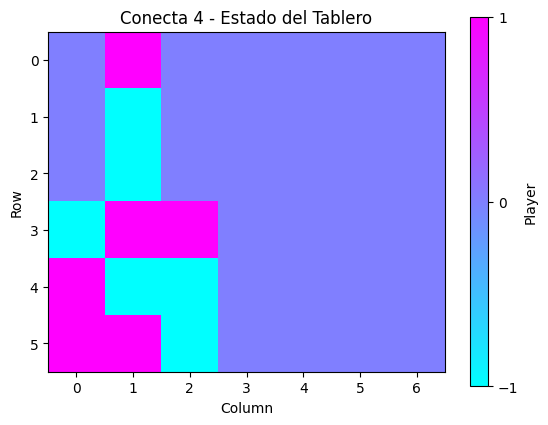

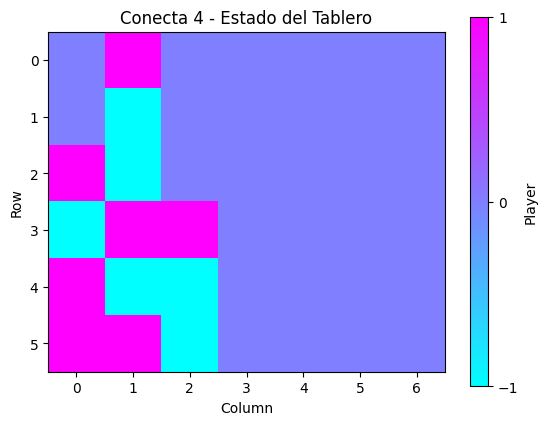

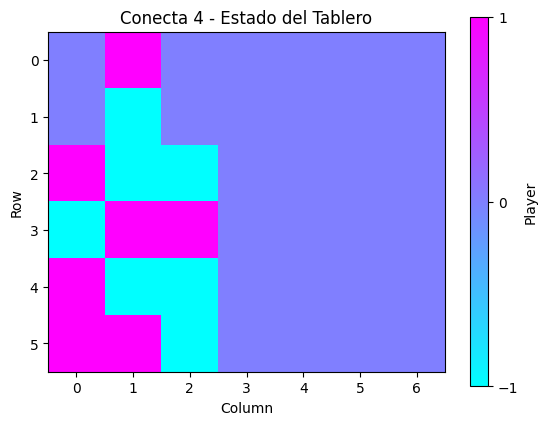

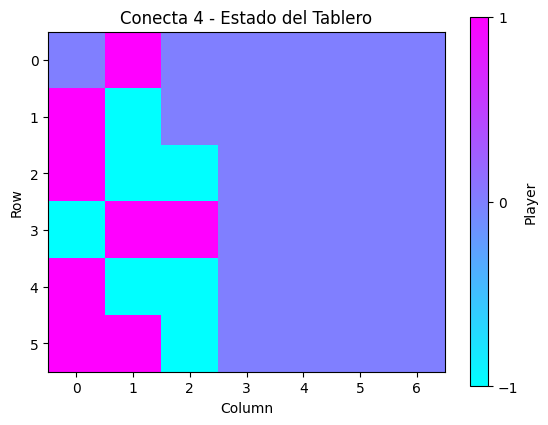

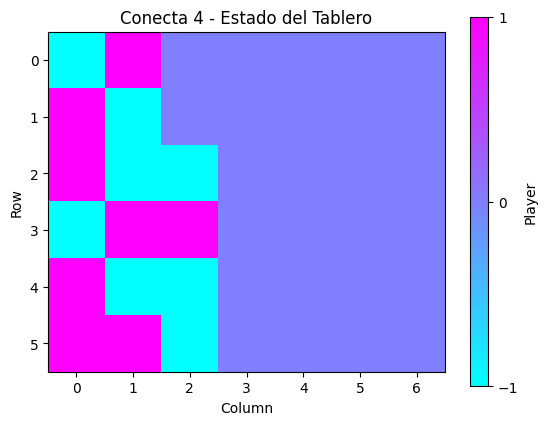

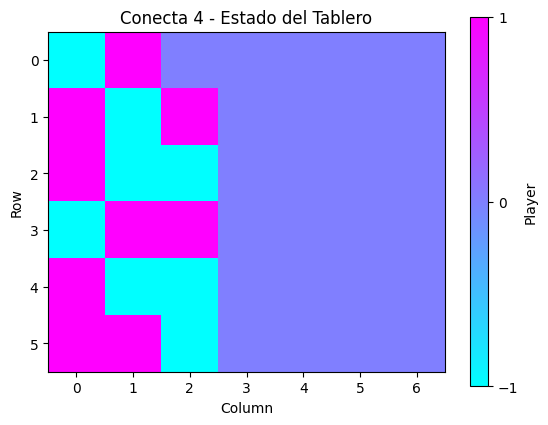

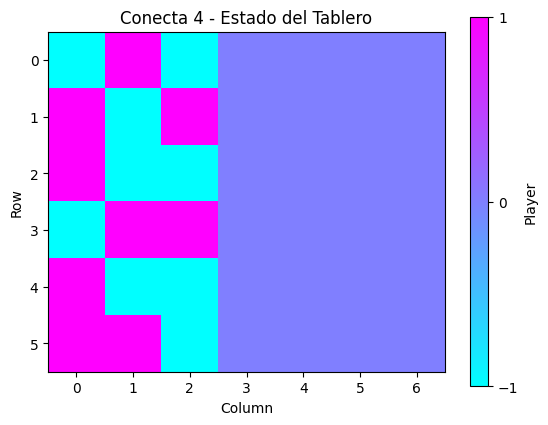

Empate


In [ ]:
# Example of starting a game with a human vs AI setup
player1 = AIPlayer(1)  # AI player
player2 = AIPlayer(-1)  # AI player as opponent for demonstration (can replace with a human player class)

game = Game(player1, player2)
game.board.reset()

# Simulate a single game between two AI players, displaying the board after each move
game_over = False
while not game_over:
    for player in game.players:
        action = player.move(game.board)
        game.board.update(player.symbol, action)
        display_board(game.board.state)
        if game.board.is_game_over() is not None:
            game_over = True
            break

winner = game.board.is_game_over()
if winner == 0:
    print("Empate")
elif winner == 1:
    print("Jugador 1 (IA) gana")
else:
    print("Jugador 2 (IA) gana")